In [1]:
import numpy as np
import pickle
import imageio.v2 as imageio
import cv2
import sys

sys.path.append("../")
from utils import data_utils, calc_utils
from speed import coord

## Load ground truth data

In [2]:
def load_ground_truth(track_idx):
    pkl_path = f"/data2/speed-lyft/tracks/track_{track_idx}.pkl"
    with open(pkl_path, "rb") as f:
        track = pickle.load(f)

    gt_velocity_mps = []
    for t in track["track_frames"]:
        gt_velocity_mps.append(t["velocity_mps"])
    gt_velocity_mps = np.array(gt_velocity_mps)

    for i, t in enumerate(track["track_frames"]):
        if i == 0:
            track["track_frames"][0]["ego_velocity_mps"] = None
        else:
            src = np.array(track["track_frames"][i - 1]["ego_pose_translation"])
            dst = np.array(t["ego_pose_translation"])
            velocity_mps = np.linalg.norm(dst - src)
            track["track_frames"][i]["ego_velocity_mps"] = velocity_mps

    ego_velocity = [t["ego_velocity_mps"] for t in track["track_frames"]]
    ego_velocity = np.array(ego_velocity[1:])

    intrinsic_mat = track["track_frames"][0]["intrinsic"]
    intrinsic = {
        "cx": intrinsic_mat[0][2],
        "cy": intrinsic_mat[1][2],
        "focalx": intrinsic_mat[0][0],
        "focaly": intrinsic_mat[1][1],
    }
    
    return track, gt_velocity_mps, ego_velocity, intrinsic

## Load trajectory

In [3]:
def load_trajectory(track_idx, idx_range):
    traj_path = f"./outputs/lyft_track_{track_idx}/trajectories/track.npy"
    with open(traj_path, "rb") as f:
        trajectories = np.load(f, allow_pickle=True).item()
    trajectories.build_invert_indexes()

    traj = trajectories.sample_inside_window(
        idx_range.tolist(),
        min_length=3,
        max_num_tracks=300,
    )

    # Extract traj locs, mask, ids
    xy = np.concatenate(
        [traj["locations"][0][:, :, None], traj["locations"][1][:, :, None]],
        2,
    )

    mask = traj["masks"].astype(float)[:, :, None]
    ids = np.array(traj["traj_ids"])
    
    return xy, mask, ids

## Load frames

In [4]:
dim = (1024, 1224)

def load_frames(track):
    rgbs, deps = [], []
    for frame in track["track_frames"]:
        # Load rgb
        im = imageio.imread(frame["rgb_path"]).astype(np.uint8)
        im_shape = im.shape
        im = cv2.resize(im, dim)

        # Load dep
        dep = data_utils.create_depth_frame(
            frame["dep_path"],
            disparity=True,
            dim=im_shape[:2],
        ).astype(np.uint8)
        dep.resize(dim + (3,))

        rgbs.append(im)
        deps.append(dep)
    
    return rgbs, deps

## Process trajectories

### Convert 2D pixel -> 3D coordinate

In [9]:
def convert_to_3d(frame, pix, dep):
    pt = calc_utils.uvd_to_xyz(pix[0], pix[1], dep, intrinsic)
    
    cam_rot = coord.convert_quarternion(frame["cam_pose_rotation"])
    ego_rot = coord.convert_quarternion(frame["ego_pose_rotation"])
    rot = cam_rot * ego_rot
    
    cam_trans = np.array(frame["cam_pose_translation"])
    ego_trans = np.array(frame["ego_pose_translation"])
    trans = cam_trans + ego_trans
    
    pt = coord.transform(pt, rot, trans)
    return pt

In [38]:
def process_trajectory(track, xy, idx_range, ego_velocity, intrinsic):
    N = xy.shape[0]
    L = xy.shape[1]

    traj_list = []
    track_frames = track["track_frames"]

    rgbs, deps = load_frames(track)

    # trajectory index
    for i in range(N):
        single_traj = xy[i]
        single_mask = mask[i]

        # timestep
        frame_list, pts_list = [], []
        src_px = None
        prev = None
        for j in range(L):
            if prev is None and single_mask[j] == 1:
                prev = single_traj[j].astype(int)
            elif prev is not None and single_mask[j] == 1:
                src = prev
                dst = single_traj[j].astype(int)

                if src_px is None:
                    src_px = src

                frame_idx = idx_range[j]
                rgb = rgbs[frame_idx]
                dep = deps[frame_idx]
                frame = track_frames[frame_idx]

                src_3d = convert_to_3d(frame, src, dep[src[1], src[0]])
                dst_3d = convert_to_3d(frame, dst, dep[dst[1], dst[0]])
                pts_list += [dst_3d]
                frame_list += [frame_idx]

                prev = dst

        src, dst = pts_list[0], pts_list[-1]
        start_idx, end_idx = frame_list[0], frame_list[-1]

        displacement_m = np.linalg.norm(dst - src)
        start_ts = track_frames[start_idx]["timestamp"]
        end_ts = track_frames[end_idx]["timestamp"]
        duration_sec = end_ts - start_ts
        speed_mps = displacement_m / duration_sec + ego_velocity.mean()

        traj_list.append(
            {
                "traj_idx": i,
                "src_px": src_px,
                "speed_mps": speed_mps,
                "duration_sec": duration_sec,
                "length_frames": len(frame_list),
                "start_ts": start_ts,
                "end_ts": end_ts,
                "start_idx": start_idx,
                "end_idx": end_idx,
            }
        )
    
    return traj_list

### Extract trajectory stats
Before running this notebook, you need to:
1. Change to the particlesfm evn: `conda activate particlesfm`
2. Run load_frames.py to copy the frames to the local folder, e.g.,:
```
python load_frames.py --track 92
```
3. Run particlesfm, e.g.,:
```
python run_particlesfm.py --image_dir ./example/lyft_track_92 --output_dir ./outputs/lyft_track_92 --keep_intermediate
```

In [65]:
track_idx = 17
frame_idx_range = np.array(np.arange(0, 100))
track, gt_velocity_mps, ego_velocity, intrinsic = load_ground_truth(track_idx)
xy, mask, ids = load_trajectory(track_idx, frame_idx_range)
traj_list = process_trajectory(track, xy, frame_idx_range, ego_velocity, intrinsic)

## Plots

In [57]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [58]:
df = pd.DataFrame.from_dict(traj_list)
df = df[df["duration_sec"] >= 1]

In [59]:
df.quantile(q=0.5)

traj_idx         1.510000e+02
speed_mps        2.063421e+01
duration_sec     1.200884e+00
length_frames    7.000000e+00
start_ts         1.546901e+09
end_ts           1.546901e+09
start_idx        1.000000e+00
end_idx          1.000000e+01
Name: 0.5, dtype: float64

8.518059460735344

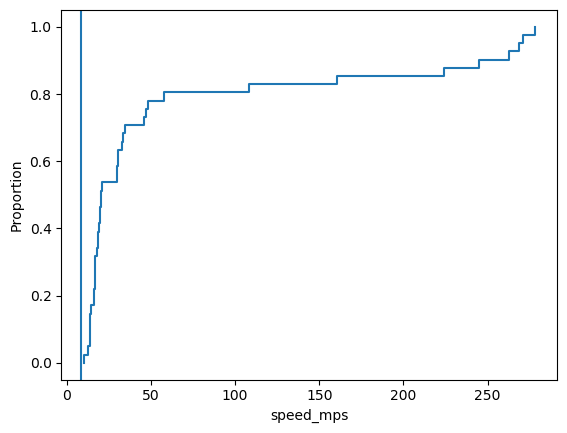

In [60]:
sns.ecdfplot(data=df, x = "speed_mps")
plt.axvline(x=gt_velocity_mps.mean())
gt_velocity_mps.mean()

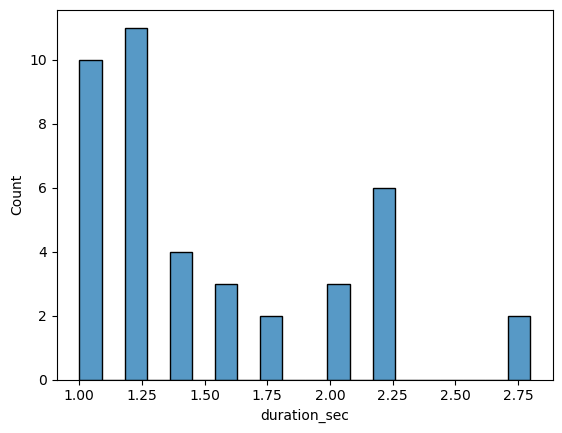

In [61]:
sns.histplot(data=df, x = "duration_sec", bins=20)

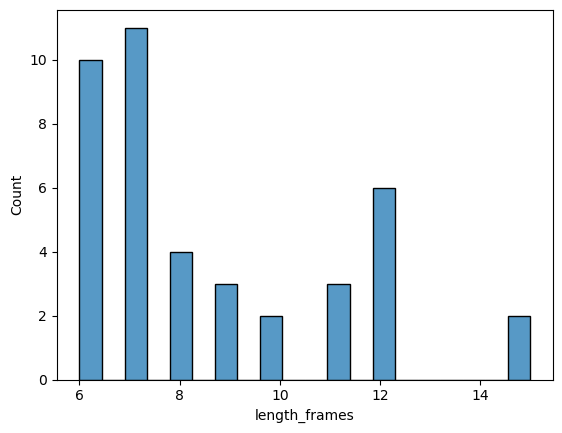

In [62]:
sns.histplot(data=df, x = "length_frames", bins=20)

In [63]:
segs = []
for idx, row in df.iterrows():
    segs.append(
        {
            "traj_idx": row["traj_idx"],
            "frame_idx": row["start_idx"],
            "speed_mps": row["speed_mps"],
        }
    )
    segs.append(
        {
            "traj_idx": row["traj_idx"],
            "frame_idx": row["end_idx"],
            "speed_mps": row["speed_mps"],
        }
    )

segs = pd.DataFrame.from_dict(segs)

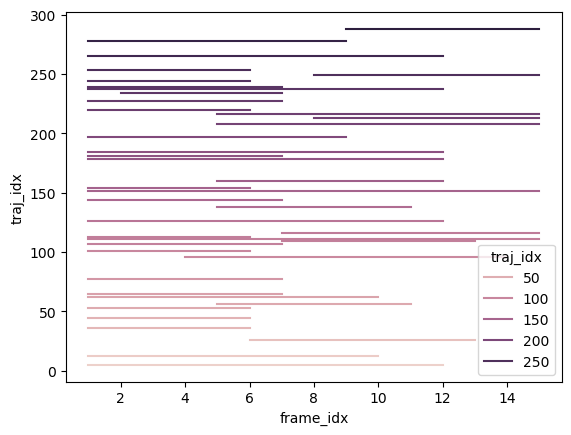

In [64]:
sns.lineplot(data=segs, x = "frame_idx", y = "traj_idx", hue = "traj_idx")